In [303]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import datetime
import matplotlib.pyplot as plt

# 1.)

In [304]:
# calc merton default probability with GBM distributed Assets 

def calc_pt(B, Vt, r, sigma, T, t):
    
    num = np.log(B / Vt) - (r - sigma**2 / 2) * (T - t)
    denom = sigma * np.sqrt(T - t)
    
    prob = norm.cdf(num / denom)
    
    return prob 

In [305]:
# a.)
res = calc_pt(1000000, 1300000, 0.01, 0.3, 5, 0)
res

0.44819026955711155

In [ ]:
# the real world default probability is the risk neutral default probability - risk premium
# risk premium = expected asset return - risk free rate = 0.025 - 0.010 = 0.015
# -> we calculated risk neutral default probability = 0.45 -> 0.45 - 0.015 = 0.435

In [306]:
# b.)

res1 = calc_pt(1000000, 1300000, 0.01, 0.3, 4, 0)
res2 = calc_pt(1000000, 1300000, 0.01, 0.3, 3, 0)
dif = res1 - res2
dif

0.03819704386724432

# 2.)

In [307]:
################ RISK measures 
# var for gbm stock 

def VaR_gbm(s0, mu, sigma, t, p):
    
    icdf = norm.ppf(1-p)
    v1 = sigma*(t**0.5)*icdf + (mu - (sigma**2)/2)*t
    v = s0 - s0 * np.exp(v1)
    
    return v

def calc_X(s0_x, mu_x, sigma_x, T_x, p_x):
    
    v_x = s0_x - VaR_gbm(s0_x, mu_x, sigma_x, T_x, p_x)
    
    return v_x

def calc_d1(s0, mu, sigma, T, X):
    
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(s0 / X) + (mu + (sigma**2)/2)*T)
    
    return d1

def ES_gbm(s0, mu, sigma, T, p):
    
    X = calc_X(s0, mu, sigma, T, p)
    
    d1 = calc_d1(s0, mu, sigma, T, X)
    
    ES = s0 - (1 / (1 - p)) * np.exp(mu * T) * s0 * (1 - norm.cdf(d1))
    
    return ES

In [308]:
ba = pd.read_csv('BA-bloomberg.csv')
noc = pd.read_csv('NOC-bloomberg.csv')

# transform string to datetime object, aufpassen mit den genauen definitionen der anteile: %m/%d/%Y -> Y für 2022, net 22

ba['Dates'] = [datetime.datetime.strptime(d, '%m/%d/%Y') for d in ba["Dates"]]
noc['Dates'] = [datetime.datetime.strptime(d, '%m/%d/%Y') for d in noc["Dates"]]

In [309]:
# create port value for stocks 

ba['port_val'] = ba.PX_LAST * 134
noc['port_val'] = noc.PX_LAST * 166

ba['log_ret'] = np.log(ba.PX_LAST) - np.log(ba.PX_LAST.shift(-1))
noc['log_ret'] = np.log(noc.PX_LAST) - np.log(noc.PX_LAST.shift(-1))

ba['ret'] = ((ba.PX_LAST) - (ba.PX_LAST).shift(-1)) / (ba.PX_LAST).shift(-1)
noc['ret'] = ((noc.PX_LAST) - (noc.PX_LAST).shift(-1)) / (noc.PX_LAST).shift(-1)

In [310]:
# port dataframe 
port = pd.DataFrame([ba.port_val, noc.port_val]).transpose()
port['port_ges_0'] = ba.port_val + noc.port_val
port['port_ges'] = np.log(port['port_ges_0']) - np.log(port['port_ges_0'].shift(-1))
port['port_ges_1'] = ba.port_val + noc.port_val
# calc log port returns 
port['port_ges_ret'] = ((port['port_ges_1']) - (port['port_ges_1']).shift(-1)) / (port['port_ges_1']).shift(-1)

port['Dates'] = ba['Dates']

# set index for rolling port
port2 = port.set_index('Dates')
port2 = port2.sort_index()
# set index for rolling ba
ba2 = ba.set_index('Dates')
ba2 = ba2.sort_index()
# set index for rolling ba
noc2 = noc.set_index('Dates')
noc2 = noc2.sort_index()

In [311]:
# calc port sd 5 year window
port_sigma5 = port2.rolling('1825d').std().shift(1)
port_sigma_new5 = port_sigma5[port_sigma5.index > '2002-10-26']
# Adjust sd
port_sigma_new5['port_ges'] = port_sigma_new5['port_ges'] * np.sqrt(252)
port_sigma_new5['port_ges_ret'] = port_sigma_new5['port_ges_ret'] * np.sqrt(252)


# calc port mean 5 year window 
port_mu5 = port2.rolling('1825d').mean().shift(1)
port_mu_new5 = port_mu5[port_mu5.index > '2002-10-26']
# Adjust mu
port_mu_new5['port_ges'] = port_mu_new5['port_ges'] * 252 + 0.5 * (port_sigma_new5['port_ges']**2)
# adjust absolute return
port_mu_new5['port_ges_ret'] = port_mu_new5['port_ges_ret'] * 252 + 0.5 * (port_sigma_new5['port_ges_ret']**2)

# calculate rolling sd for 5 year rolling BA
ba2_sigma = ba2.rolling('1825d').std().shift(1)
ba2_sigma_filter = ba2_sigma[ba2_sigma.index > '2002-10-26']
# Adjust sigma
ba2_sigma_filter['log_ret'] = ba2_sigma_filter['log_ret'] * np.sqrt(252)
ba2_sigma_filter = ba2_sigma_filter.rename(columns={'log_ret': 'log_ret_sig'})
# Adjust absolute return sigma
ba2_sigma_filter['ret'] = ba2_sigma_filter['ret'] * np.sqrt(252)
ba2_sigma_filter = ba2_sigma_filter.rename(columns={'ret': 'ret_sig'})

# calculate rolling means for 5 year rolling BA
ba2_mu = ba2.rolling('1825d').mean().shift(1)
ba2_mean_filter = ba2_mu[ba2_mu.index > '2002-09-22']
# Adjust mu
ba2_mean_filter['log_ret'] = ba2_mean_filter['log_ret'] * 252 + 0.5 * (ba2_mean_filter['log_ret']**2)
ba2_mean_filter = ba2_mean_filter.rename(columns={'log_ret': 'log_ret_mu'})
# Adjust absolute return mu
ba2_mean_filter['ret'] = ba2_mean_filter['ret'] * 252 + 0.5 * (ba2_mean_filter['ret']**2)
ba2_mean_filter = ba2_mean_filter.rename(columns={'ret': 'ret_mu'})

# calculate rolling sd for 5 year rolling NOC
noc2_sigma = noc2.rolling('1825d').std().shift(1)
noc2_sigma_filter = noc2_sigma[noc2_sigma.index > '2002-10-26']
# Adjust sigma
noc2_sigma_filter['log_ret'] = noc2_sigma_filter['log_ret'] * np.sqrt(252)
noc2_sigma_filter = noc2_sigma_filter.rename(columns={'log_ret': 'log_ret_sig'})
# Adjust absolute return mu
noc2_sigma_filter['ret'] = noc2_sigma_filter['ret'] * np.sqrt(252)
noc2_sigma_filter = noc2_sigma_filter.rename(columns={'ret': 'ret_sig'})

# calculate rolling means for 5 year rolling NOC
noc2_mu = noc2.rolling('1825d').mean().shift(1)
noc2_mean_filter = noc2_mu[noc2_mu.index > '2002-09-22']
# Adjust mu
noc2_mean_filter['log_ret'] = noc2_mean_filter['log_ret'] * 252 + 0.5 * (noc2_mean_filter['log_ret']**2)
noc2_mean_filter = noc2_mean_filter.rename(columns={'log_ret': 'log_ret_mu'})
# Adjust absolute return sigma
noc2_mean_filter['ret'] = noc2_mean_filter['ret'] * 252 + 0.5 * (noc2_mean_filter['ret']**2)
noc2_mean_filter = noc2_mean_filter.rename(columns={'ret': 'ret_mu'})

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/1636250746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_sigma_new5['port_ges'] = port_sigma_new5['port_ges'] * np.sqrt(252)
/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/1636250746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  port_sigma_new5['port_ges_ret'] = port_sigma_new5['port_ges_ret'] * np.sqrt(252)
/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/1636250746.py:13: SettingWithCopyWarn

In [312]:
# get array for all sigma and mu 5 years

ba2_mu_sigma = pd.DataFrame([ba2_mean_filter.log_ret_mu, ba2_sigma_filter.log_ret_sig, 
                             ba2_mean_filter.ret_mu, ba2_sigma_filter.ret_sig]).transpose()
noc2_mu_sigma = pd.DataFrame([noc2_mean_filter.log_ret_mu, noc2_sigma_filter.log_ret_sig, 
                              noc2_mean_filter.ret_mu, noc2_sigma_filter.ret_sig]).transpose()

In [313]:
# rename port mu and sigma values and put them together for df with all metrics

# Log return cols

port_mu_new5 = port_mu_new5.rename(columns={'port_ges': 'port_ges_mu5'})

port_sigma_new5 = port_sigma_new5.rename(columns={'port_ges': 'port_ges_std5'})

# Absolute return cols

port_mu_new5 = port_mu_new5.rename(columns={'port_ges_ret': 'port_ges_mu5_ret'})

port_sigma_new5 = port_sigma_new5.rename(columns={'port_ges_ret': 'port_ges_std5_ret'})

df_mu_sigma = pd.DataFrame([port_mu_new5.port_ges_mu5, 
                            port_sigma_new5.port_ges_std5, 
                            port_mu_new5.port_ges_mu5_ret, 
                            port_sigma_new5.port_ges_std5_ret]).transpose()

In [314]:
# generate price list
ba_price = ba[ba['Dates'] > '2002-10-26']['PX_LAST']
noc_price = noc[noc['Dates'] > '2002-10-26']['PX_LAST']
# reverse df
ba_price = ba_price.iloc[::-1].reset_index(drop=True)
noc_price = noc_price.iloc[::-1].reset_index(drop=True)

In [315]:
df_mu_sigma['VaR_5'] = ''

df_mu_sigma['ES_5'] = ''

In [316]:
# VaR for window 5 years port

for i in range(len(df_mu_sigma)):
    
    #134 * ba_price[i] + 166 * noc_price[i]
    
    v0 = 10000
    
    df_mu_sigma['VaR_5'][i] = VaR_gbm(v0, df_mu_sigma.iloc[i]['port_ges_mu5'], 
                                           df_mu_sigma.iloc[i]['port_ges_std5'], 
                                           5 / 252, 0.99) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/988368624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu_sigma['VaR_5'][i] = VaR_gbm(v0, df_mu_sigma.iloc[i]['port_ges_mu5'],


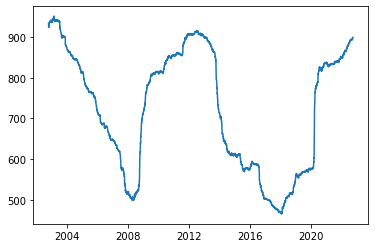

In [317]:
plt.plot(df_mu_sigma['VaR_5'])

In [318]:
# ES for window 5 years port

for i in range(len(df_mu_sigma)):
    
    # 134 * ba_price[i] + 166 * noc_price[i]
    
    v0 = 10000
    
    df_mu_sigma['ES_5'][i] = ES_gbm(v0, df_mu_sigma.iloc[i]['port_ges_mu5'], 
                                           df_mu_sigma.iloc[i]['port_ges_std5'], 
                                           5 / 252, 0.975) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/1444746781.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu_sigma['ES_5'][i] = ES_gbm(v0, df_mu_sigma.iloc[i]['port_ges_mu5'],


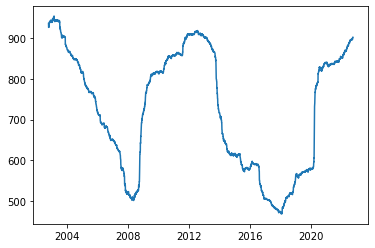

In [319]:
plt.plot(df_mu_sigma['ES_5'])

In [320]:
v0_const = 10000

In [321]:
ba2_mu_sigma['VaR_BA'] = ''

ba2_mu_sigma['ES_BA'] = ''

noc2_mu_sigma['VaR_NOC'] = ''

noc2_mu_sigma['ES_NOC'] = ''

In [322]:
# VaR for 5 year window BA

for i in range(len(ba2_mu_sigma)):
    
    ba2_mu_sigma['VaR_BA'][i] = VaR_gbm(v0_const, ba2_mu_sigma.iloc[i]['log_ret_mu'], 
                                           ba2_mu_sigma.iloc[i]['log_ret_sig'], 
                                           5 / 252, 0.99) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/1712544381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba2_mu_sigma['VaR_BA'][i] = VaR_gbm(v0_const, ba2_mu_sigma.iloc[i]['log_ret_mu'],


In [323]:
# ES for 5 year window ES

for i in range(len(ba2_mu_sigma)):
    
    ba2_mu_sigma['ES_BA'][i] = ES_gbm(v0_const, ba2_mu_sigma.iloc[i]['log_ret_mu'], 
                                           ba2_mu_sigma.iloc[i]['log_ret_sig'], 
                                           5 / 252, 0.975) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/644155256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba2_mu_sigma['ES_BA'][i] = ES_gbm(v0_const, ba2_mu_sigma.iloc[i]['log_ret_mu'],


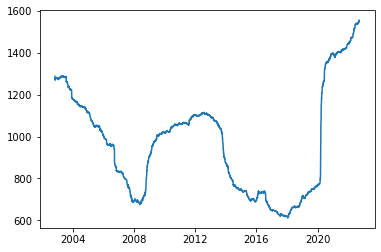

In [324]:
# BA VaR plot

plt.plot(ba2_mu_sigma['VaR_BA'])

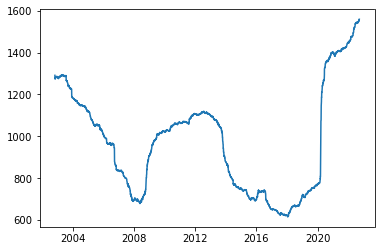

In [325]:
# BA ES plot

plt.plot(ba2_mu_sigma['ES_BA'])

In [326]:
# VaR for 5 year window BA

for i in range(len(noc2_mu_sigma)):
    
    noc2_mu_sigma['VaR_NOC'][i] = VaR_gbm(v0_const, noc2_mu_sigma.iloc[i]['log_ret_mu'], 
                                           noc2_mu_sigma.iloc[i]['log_ret_sig'], 
                                           5 / 252, 0.99) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/4034463293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noc2_mu_sigma['VaR_NOC'][i] = VaR_gbm(v0_const, noc2_mu_sigma.iloc[i]['log_ret_mu'],


In [327]:
# ES for 5 year window ES

for i in range(len(noc2_mu_sigma)):
    
    noc2_mu_sigma['ES_NOC'][i] = ES_gbm(v0_const, noc2_mu_sigma.iloc[i]['log_ret_mu'], 
                                           noc2_mu_sigma.iloc[i]['log_ret_sig'], 
                                           5 / 252, 0.975) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/3585390189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noc2_mu_sigma['ES_NOC'][i] = ES_gbm(v0_const, noc2_mu_sigma.iloc[i]['log_ret_mu'],


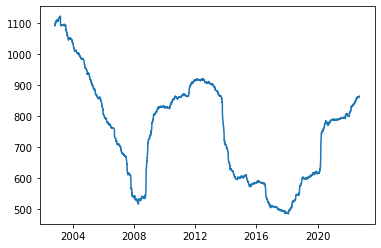

In [328]:
# BA VaR plot

plt.plot(noc2_mu_sigma['VaR_NOC'])

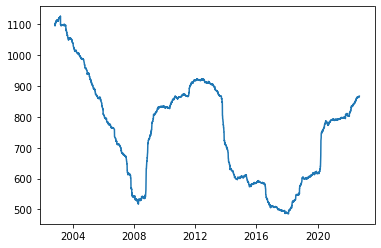

In [329]:
# BA ES plot

plt.plot(noc2_mu_sigma['ES_NOC'])

# 3.)

In [338]:
df_mu_sigma['VaR_5_abs'] = ''

df_mu_sigma['ES_5_abs'] = ''

In [331]:
# VaR for window 5 years portfolio

for i in range(len(df_mu_sigma)):
    
    #134 * ba_price[i] + 166 * noc_price[i]
    
    v0 = 10000
    
    df_mu_sigma['VaR_5_abs'][i] = VaR_gbm(v0, df_mu_sigma.iloc[i]['port_ges_mu5_ret'], 
                                           df_mu_sigma.iloc[i]['port_ges_std5_ret'], 
                                           5 / 252, 0.99) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/2587992924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu_sigma['VaR_5_abs'][i] = VaR_gbm(v0, df_mu_sigma.iloc[i]['port_ges_mu5_ret'],


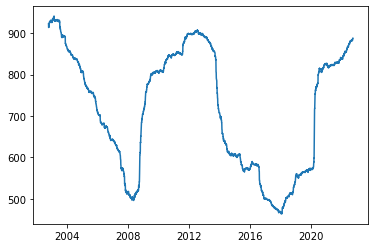

In [332]:
# PORT VaR plot

plt.plot(df_mu_sigma['VaR_5_abs'])

In [341]:
# ES for 5 year window ES

for i in range(len(df_mu_sigma)):
    
    df_mu_sigma['ES_5_abs'][i] = ES_gbm(v0_const, df_mu_sigma.iloc[i]['port_ges_mu5_ret'], 
                                           df_mu_sigma.iloc[i]['port_ges_std5_ret'], 
                                           5 / 252, 0.975) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/3674476592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu_sigma['ES_5_abs'][i] = ES_gbm(v0_const, df_mu_sigma.iloc[i]['port_ges_mu5_ret'],


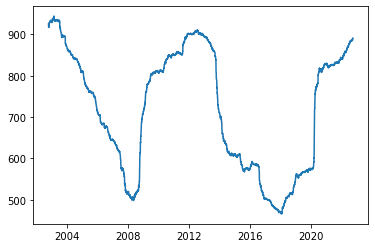

In [342]:
# PORT ES plot

plt.plot(df_mu_sigma['ES_5_abs'])

In [333]:
ba2_mu_sigma['VaR_BA_abs'] = ''

ba2_mu_sigma['ES_BA_abs'] = ''

noc2_mu_sigma['VaR_NOC_abs'] = ''

noc2_mu_sigma['ES_NOC_abs'] = ''

In [343]:
# VaR for 5 year window BA

for i in range(len(ba2_mu_sigma)):
    
    ba2_mu_sigma['VaR_BA_abs'][i] = VaR_gbm(v0_const, ba2_mu_sigma.iloc[i]['ret_mu'], 
                                           ba2_mu_sigma.iloc[i]['ret_sig'], 
                                           5 / 252, 0.99) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/2685555433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba2_mu_sigma['VaR_BA_abs'][i] = VaR_gbm(v0_const, ba2_mu_sigma.iloc[i]['ret_mu'],


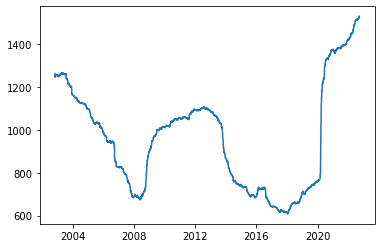

In [344]:
plt.plot(ba2_mu_sigma['VaR_BA_abs'])

In [346]:
# ES for 5 year window BA

for i in range(len(ba2_mu_sigma)):
    
    ba2_mu_sigma['ES_BA_abs'][i] = ES_gbm(v0_const, ba2_mu_sigma.iloc[i]['ret_mu'], 
                                           ba2_mu_sigma.iloc[i]['ret_sig'], 
                                           5 / 252, 0.975) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/3655324786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba2_mu_sigma['ES_BA_abs'][i] = ES_gbm(v0_const, ba2_mu_sigma.iloc[i]['ret_mu'],


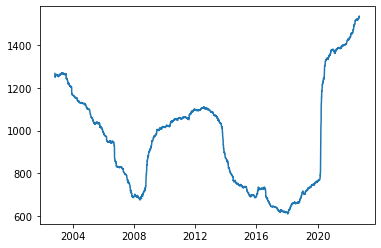

In [348]:
plt.plot(ba2_mu_sigma['ES_BA_abs'])

In [353]:
# VaR for 5 year window NOC

for i in range(len(noc2_mu_sigma)):
    
    noc2_mu_sigma['VaR_NOC_abs'][i] = VaR_gbm(v0_const, noc2_mu_sigma.iloc[i]['ret_mu'], 
                                           noc2_mu_sigma.iloc[i]['ret_sig'], 
                                           5 / 252, 0.99) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/2701770755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noc2_mu_sigma['VaR_NOC_abs'][i] = VaR_gbm(v0_const, noc2_mu_sigma.iloc[i]['ret_mu'],


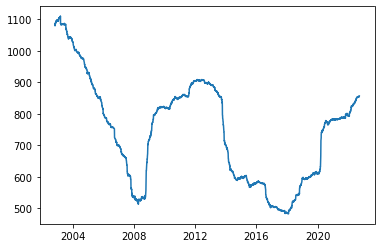

In [354]:
plt.plot(noc2_mu_sigma['VaR_NOC_abs'])

In [356]:
# ES for 5 year window NOC

for i in range(len(noc2_mu_sigma)):
    
    noc2_mu_sigma['ES_NOC_abs'][i] = ES_gbm(v0_const, noc2_mu_sigma.iloc[i]['ret_mu'], 
                                           noc2_mu_sigma.iloc[i]['ret_sig'], 
                                           5 / 252, 0.975) 

/var/folders/sn/xxr4rfmj23100534fjn99hv80000gn/T/ipykernel_75076/4160660047.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noc2_mu_sigma['ES_NOC_abs'][i] = ES_gbm(v0_const, noc2_mu_sigma.iloc[i]['ret_mu'],


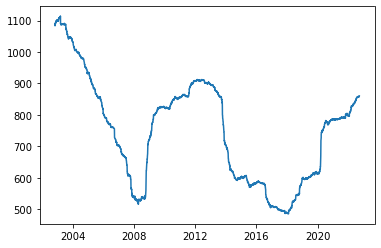

In [357]:
plt.plot(noc2_mu_sigma['ES_NOC_abs'])